# Table of Contents


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_t

import numpy as onp
import matplotlib.pyplot as plt # visualization

import jax
from jax import ops
import jax.numpy as np
from jax import jit, grad, value_and_grad, random
from jax import lax
from jax.random import split
from jax.tree_util import tree_multimap
from jax import vmap
from jax.tree_util import Partial as partial

from jax.experimental import optix
from jax.experimental import optimizers
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers

In [3]:
rng = random.PRNGKey(0)
rng

/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([0, 0], dtype=uint32)

In [4]:
def sample_tasks(rng, outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    rng, rngA, rngP = split(rng, 3)
    As = random.uniform(rngA, shape=(outer_batch_size,), minval=0.1, maxval=5.0)
    phases = random.uniform(rngP, shape=(outer_batch_size,), minval=0, maxval=np.pi)
    
    def get_batch(rng):
        xs = np.empty((outer_batch_size, inner_batch_size, 1))
        ys = np.empty((outer_batch_size, inner_batch_size, 1))
        rngs = split(rng, outer_batch_size)
        for i, (A, phase, rng) in enumerate(zip(As, phases, rngs)):
            x = random.uniform(rng, shape=(inner_batch_size, 1), minval=-5., maxval=5., )
            y = A * np.sin(x + phase)
            xs = ops.index_update(xs, i, x)
            ys = ops.index_update(ys, i, y)
        return xs, ys
    rng2, rng3 = split(rng, 2)
    x1, y1 = get_batch(rng2)
    x2, y2 = get_batch(rng3)
    return x1, y1, x2, y2, As, phases

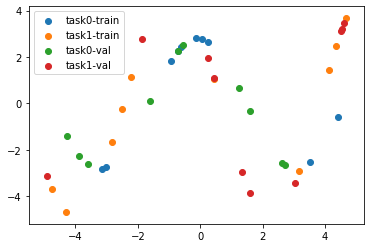

In [5]:
rng, rng_sample = split(rng, 2)
x1, y1, x2, y2, As, phases = sample_tasks(rng, 2, 10)

for i in range(x1.shape[0]):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(x1.shape[0]):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [6]:
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1),
)

def make_net(rng, in_shape=(-1, 1)):
    rng, rng_net = split(rng, 2)
    return net_init(rng_net, in_shape)

def mse_loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions) ** 2)

# Train vanilla

In [7]:
xrange_inputs = np.linspace(-5, 5, 100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

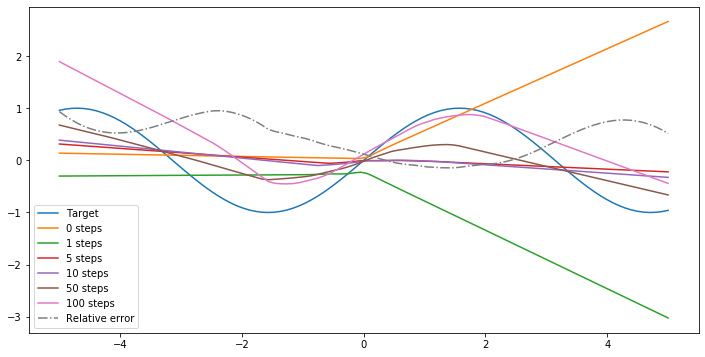

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, targets, label="Target")

out_shape, net_params = make_net(rng)
opt_init, opt_update, get_params = optimizers.sgd(1e-1)
opt_state = opt_init(net_params)

ax.plot(xrange_inputs, net_apply(net_params, xrange_inputs), label="0 steps")
plot_steps = [1, 5, 10, 50, 100]
for i in range(1, 101):
    loss, grads = value_and_grad(mse_loss)(net_params, xrange_inputs, targets)
    opt_state = opt_update(i - 1, grads, opt_state)
    net_params = get_params(opt_state)
    
    if i in plot_steps:
        preds = net_apply(net_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % i)

pointwise_loss = (preds - targets)
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.legend()

# MAML Methods

In [9]:
inner_opt = optix.sgd(1e-3)

@jit
def get_updates(params, x, y, opt_state):
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    return inner_opt.update(grads, opt_state, params), loss

@jit
def single_update(params, x, y, opt_state=None):
    (updates, new_state), loss = get_updates(params, x, y, opt_state)
    params = optix.apply_updates(params, updates)
    return (params, new_state), loss

def k_updates(params, x, y, k, opt_state, opt_update):
    opt_state = inner_opt.init(params)
    loss_history = []
    for _ in range(k):
        (params, opt_state), pre_step_loss = single_update(params, x, y, opt_state)
        loss_history.append(loss)
    return (params, opt_state), loss_history

def jittable_k_updates(params, x, y, k, opt_state, opt_update):
    loss_history = np.zeros(k + 1)
    initial_loss = mse_loss(params, x, y)
    loss_history = ops.index_update(loss_history, 0, initial_loss)
    for i in range(k):
        grads = grad(mse_loss)(params, x, y)
        updates, opt_state = opt_update(grads, opt_state, params)
        params = optix.apply_updates(params, updates)
        loss = mse_loss(params, x, y)
        loss_history = ops.index_update(loss_history, i + 1, loss)
    return (params, opt_state), loss_history

def jittable_maml_loss(params, x_in, y_in, x_out, y_out, k, inner_opt):
    opt_state = inner_opt.init(params)
    (params, _), inner_loss = jittable_k_updates(params, x_in, y_in, k, opt_state, inner_opt.update)
    return mse_loss(params, x_out, y_out), inner_loss

def jittable_outer_loss_and_grads(params, x_in, y_in, x_out, y_out, k):
    return value_and_grad(jittable_maml_loss, has_aux=True)(params, x_in, y_in, x_out, y_out, k)

# Single batch

In [24]:
## 
inner_opt = optix.sgd(1e-3)
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = make_net(rng)
outer_opt_state = outer_opt_init(net_params)

num_inner_steps = 1

@jit
def maml_loss(params, x_in, y_in, x_out, y_out):
    return jittable_maml_loss(
        params, x_in, y_in, x_out, y_out, num_inner_steps, inner_opt,
    )

jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))
@jit
# def step(i, opt_state, x1, y1, x2, y2):
def step(i, opt_state, rng_task):
    x1, y1, x2, y2, _, _ = jit_sample_tasks(rng_task, 1, 10)
    p = outer_get_params(opt_state)
    (outer_loss, inner_loss), outer_grads = value_and_grad(maml_loss, has_aux=True)(
        p, x1[0], y1[0], x2[0], y2[0],
    )
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    net_params = outer_get_params(opt_state)
    final_loss = mse_loss(net_params, x2[0], y2[0])
    
    return opt_state, final_loss, inner_loss

num_outer_steps = 70000
pbar = tqdm_t(range(num_outer_steps))
np_maml_loss = []
for i in pbar:
    rng, rng_task = split(rng, 2)
    # x1, y1, x2, y2 = sample_tasks(1, 50, rng_task)
    # outer_opt_state, final_loss, inner_loss = step(i, outer_opt_state, x1, y1, x2, y2)
    outer_opt_state, final_loss, inner_loss = step(i, outer_opt_state, rng_task)

    pbar.set_postfix(
        outer_outer=final_loss, inner_loss=inner_loss[-1],
    )
    np_maml_loss.append(final_loss)
    
single_batch_params = outer_get_params(outer_opt_state)

100%|██████████| 70000/70000 [03:53<00:00, 299.73it/s, inner_loss=0.32885122, outer_outer=2.169915]     


MSE 5-shot 1 steps
0.69858634
MSE 5-shot 5 steps
0.5575979
MSE 5-shot 10 steps
0.5704194


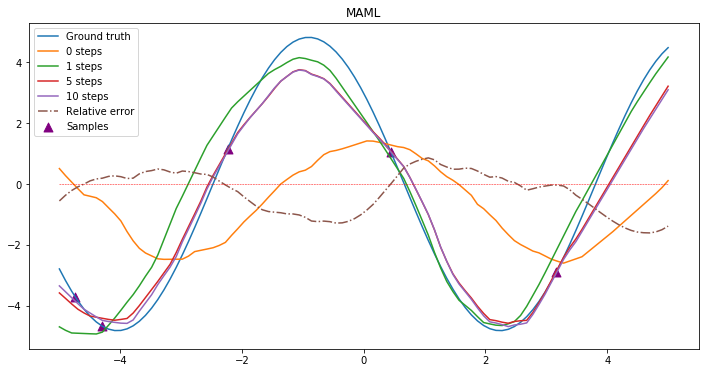

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.scatter(x1[1, :5], y1[1, :5], marker="^", label="Samples", color="purple", s=80)

new_params = single_batch_params
ax.plot(xrange_inputs, net_apply(new_params, xrange_inputs), label="0 steps")
inner_opt = optix.sgd(1e-3)
inner_opt_state = inner_opt.init(new_params)
for i in range(0, 10):
    # inner_opt_state = inner_opt.init(new_params)
    (new_params, inner_opt_state), loss = jittable_k_updates(
        new_params, x1[1, :5], y1[1, :5], k=1, opt_state=inner_opt_state, opt_update=inner_opt.update,
    )

    if (i + 1) in [1, 5, 10]:
        preds = net_apply(new_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))
        
        pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
        print("MSE 5-shot %d steps" % (i + 1))
        print((pointwise_loss ** 2).mean())

pointwise_loss = (preds - np.sin(xrange_inputs + phases[1]) * As[1])
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)

ax.legend()
ax.set_title("MAML");

# Multi batch

In [26]:
inner_opt = optix.sgd(1e-3)
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = make_net(rng)
outer_opt_state = outer_opt_init(net_params)

num_inner_steps = 1
num_tasks = 25
num_samples = 10

@jit
def jit_maml_loss(params, x_in, y_in, x_out, y_out):
    return jittable_maml_loss(params, x_in, y_in, x_out, y_out, num_inner_steps, inner_opt)

@jit
def batch_outer_loss(p, x1_b, y1_b, x2_b, y2_b):
    outer_losses, inner_losses = vmap(partial(jit_maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return outer_losses.mean(), inner_losses.mean(0)

jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))

@jit
def step(i, opt_state, rng_task):
    x1, y1, x2, y2, _, _ = jit_sample_tasks(rng_task, num_tasks, num_samples)
    p = outer_get_params(opt_state)
    (outer_loss, inner_loss), outer_grads = value_and_grad(
        batch_outer_loss, has_aux=True
    )(p, x1, y1, x2, y2)
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    net_params = outer_get_params(opt_state)
    # final_loss = mse_loss(net_params, x2[0], y2[0])
    
    return opt_state, outer_loss, inner_loss

num_outer_steps = 70000
pbar = tqdm_t(range(num_outer_steps))
np_batched_maml_loss = []
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, outer_loss, inner_loss = step(i, outer_opt_state, rng_task)

    pbar.set_postfix(
        outer_loss=outer_loss, inner_loss=inner_loss[-1],
    )
    np_batched_maml_loss.append(outer_loss)
    
multi_batch_params = outer_get_params(outer_opt_state)

100%|██████████| 70000/70000 [06:01<00:00, 193.86it/s, inner_loss=0.28383127, outer_loss=0.35137016] 


MSE 5-shot 1 steps
1.1246386
MSE 5-shot 5 steps
0.6814825
MSE 5-shot 10 steps
0.6974471


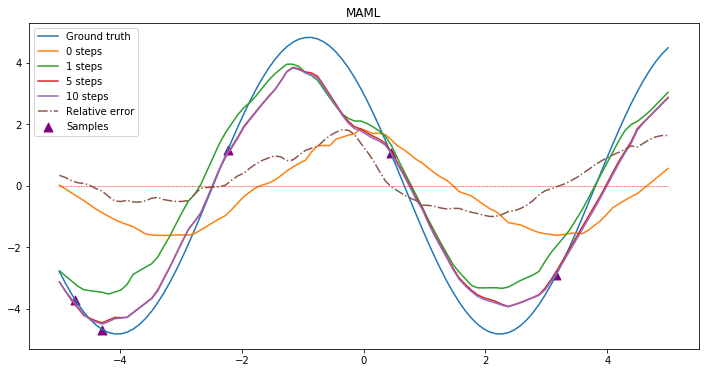

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.scatter(x1[1, :5], y1[1, :5], marker="^", label="Samples", color="purple", s=80)

new_params = multi_batch_params
ax.plot(xrange_inputs, net_apply(new_params, xrange_inputs), label="0 steps")
inner_opt = optix.sgd(1e-3)
inner_opt_state = inner_opt.init(new_params)
for i in range(0, 10):
    # inner_opt_state = inner_opt.init(new_params)
    (new_params, inner_opt_state), loss = jittable_k_updates(
        new_params, x1[1, :5], y1[1, :5], k=1, opt_state=inner_opt_state, opt_update=inner_opt.update,
    )

    if (i + 1) in [1, 5, 10]:
        preds = net_apply(new_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))

        pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
        print("MSE 5-shot %d steps" % (i + 1))
        print((pointwise_loss ** 2).mean())
        
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)


ax.legend()
ax.set_title("MAML");

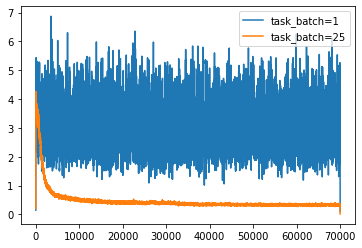

In [32]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05] * 20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=%d' % num_tasks)
# plt.ylim(0., 1e-1)
plt.legend()

# $ML^3$

In [10]:
loss_init, loss_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1), # stax.Softplus,
)

def make_loss_net(rng, in_shape=(-1, 3)):
    rng, rng_net = split(rng, 2)
    return loss_init(rng_net, in_shape)

@jit
def loss_forward(loss_params, predictions, targets):
    mse_loss = (targets - predictions) ** 2
    inp = np.concatenate((predictions, targets), -1)
    return loss_apply(loss_params, inp), mse_loss

@jit
def learned_loss(loss_params, net_params, inputs, targets):
    predictions = net_apply(net_params, inputs)
    return loss_forward(loss_params, predictions, targets)

@jit
def mean_learned_loss(loss_params, net_params, inputs, targets):
    return [l.mean() for l in learned_loss(loss_params, net_params, inputs, targets)]

def learned_k_updates(loss_params, params, x, y, k, opt_state, opt_update):
    mse_loss_history = np.zeros(k + 1)
    learned_loss_history = np.zeros(k + 1)
    for i in range(k):
        (learned_loss, mse_loss), grads = value_and_grad(mean_learned_loss, 1, has_aux=True)(loss_params, params, x, y)
        updates, opt_state = opt_update(grads, opt_state, params)
        params = optix.apply_updates(params, updates)
        
        learned_loss_history = ops.index_update(learned_loss_history, i, learned_loss)
        mse_loss_history = ops.index_update(mse_loss_history, i, mse_loss)
        
    learned_loss, mse_loss = mean_learned_loss(loss_params, params, x, y)
    learned_loss_history = ops.index_update(learned_loss_history, i + 1, learned_loss)
    mse_loss_history = ops.index_update(mse_loss_history, i + 1, mse_loss)
    
    return (params, opt_state), (learned_loss_history, mse_loss_history)

def learned_maml_loss(loss_params, params, x_in, y_in, x_out, y_out, k, inner_opt):
    opt_state = inner_opt.init(params)
    (params, _), loss_history = learned_k_updates(loss_params, params, x_in, y_in, k, opt_state, inner_opt.update)
    return mse_loss(params, x_out, y_out), (params, loss_history)

In [157]:
out_shape, loss_params = make_loss_net(rng, (-1, 2))
inner_opt = optix.sgd(1e-1)
outer_opt = optimizers.adam(step_size=1e-2)
outer_opt_state = outer_opt_init(loss_params)

jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))

num_inner_steps = 10
@jit
def jit_maml_loss(loss_params, params, x_in, y_in, x_out, y_out):
    return learned_maml_loss(
        loss_params, params, x_in, y_in, x_out, y_out, num_inner_steps, inner_opt,
    )

num_inner_samples = 100
jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))
@jit
# def step(i, opt_state, x1, y1, x2, y2):
def step(i, opt_state, rng):
    rng_task, rng_net = split(rng, 2)
    x1, y1, x2, y2, _, _ = jit_sample_tasks(rng_task, 1, num_inner_samples)
    _, net_params = make_net(rng_net)
    loss_params = outer_get_params(opt_state)
    (outer_loss, (net_params, loss_history)), outer_grads = value_and_grad(jit_maml_loss, has_aux=True)(
        loss_params, net_params, x1[0], y1[0], x2[0], y2[0],
    )
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    
    return opt_state, outer_loss, loss_history

num_outer_steps = 70000
pbar = tqdm(
    range(num_outer_steps),
    # miniters=500,
    # mininterval=5,
)
np_learned_maml_loss = []
for i in pbar:
    rng, rng_task = split(rng, 2)
    # x1, y1, x2, y2 = sample_tasks(1, 50, rng_task)
    # outer_opt_state, final_loss, inner_loss = step(i, outer_opt_state, x1, y1, x2, y2)
    outer_opt_state, outer_loss, (learned_loss_history, mse_loss_history) = step(i, outer_opt_state, rng_task)

    pbar.set_postfix(
        outer_loss=outer_loss,
        initial_learned_loss=learned_loss_history[0], final_learned_loss=learned_loss_history[-1],
        initial_mse_loss=mse_loss_history[0], final_mse_loss=mse_loss_history[-1],
        # refresh=False,
    )
    np_learned_maml_loss.append(outer_loss)
    
single_batch_learned_loss_params = outer_get_params(outer_opt_state)

In [143]:
rng, rng_net = split(rng, 2)

MSE 100-shot 0 steps
0.9162015
MSE 100-shot 1 steps
1.2177129
MSE 100-shot 5 steps
0.49672046
MSE 100-shot 10 steps
0.45537814


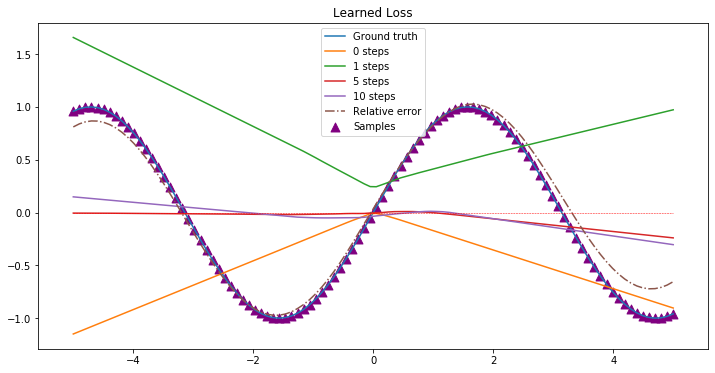

In [156]:
K = 100

X, Y = xrange_inputs[None], targets[None]

fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.plot(xrange_inputs, targets, label="Ground truth")
ax.scatter(X[1, :K], Y[1, :K], marker="^", label="Samples", color="purple", s=80)

out_shape, net_params = make_net(rng_net)
inner_opt = optix.sgd(1e-1)
opt_state = inner_opt.init(net_params)

ax.plot(xrange_inputs, net_apply(net_params, xrange_inputs), label="0 steps")
preds = net_apply(net_params, xrange_inputs)
pointwise_loss = (targets - preds)
print("MSE %d-shot %d steps" % (K, 0))
print((pointwise_loss ** 2).mean())


for i in range(10):
    (net_params, _), (_, _) = learned_k_updates(
        single_batch_learned_loss_params, net_params, X[1, :K], Y[1, :K], 1, opt_state, inner_opt.update,
    )
    
    if (i + 1) in [1, 5, 10]:
        preds = net_apply(net_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))

        # pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
        pointwise_loss = (targets - preds)
        print("MSE %d-shot %d steps" % (K, i + 1))
        print((pointwise_loss ** 2).mean())
        
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)

ax.legend()
ax.set_title("Learned Loss");

# $ML^3$ Batched

In [11]:
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    # Dense(1),
)

head_init, head_apply = Dense(1)

def multihead_apply(params, inputs):
    feats = net_apply(params[0], inputs)
    preds = head_apply(params[1], feats)
    return preds, feats

def make_multihead_net(rng, in_shape=(-1, 1)):
    rng_backbone, rng_head = split(rng, 2)
    backbone_out_shape, backbone_params = net_init(rng_backbone, in_shape)
    out_shape, head_params = head_init(rng_head, backbone_out_shape)
    return backbone_params, head_params

def mse_loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = multihead_apply(params, inputs)[0]
    return np.mean((targets - predictions) ** 2)

In [12]:
def weight_decay(params, alpha):
    return optimizers.l2_norm(params) * alpha

loss_init, loss_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1), # stax.Softplus,
)

def make_loss_net(rng, in_shape=(-1, 42)):
    rng, rng_net = split(rng, 2)
    return loss_init(rng_net, in_shape)

@jit
def loss_forward(loss_params, predictions, others, targets):
    mse_loss = (targets - predictions) ** 2
    inp = np.concatenate((predictions, others, targets), -1)
    return loss_apply(loss_params, inp), mse_loss

@jit
def learned_loss(loss_params, net_params, inputs, targets):
    predictions, features = multihead_apply(net_params, inputs)
    return loss_forward(loss_params, predictions, features, targets)

@jit
def mean_learned_loss(loss_params, net_params, inputs, targets):
    return [l.mean() for l in learned_loss(loss_params, net_params, inputs, targets)]

def learned_k_updates(loss_params, params, x, y, k, opt_state, opt_update):
    mse_loss_history = np.zeros(k + 1)
    learned_loss_history = np.zeros(k + 1)
    for i in range(k):
        (learned_loss, mse_loss), grads = value_and_grad(mean_learned_loss, 1, has_aux=True)(loss_params, params, x, y)
        updates, opt_state = opt_update(grads, opt_state, params)
        params = optix.apply_updates(params, updates)
        
        learned_loss_history = ops.index_update(learned_loss_history, i, learned_loss)
        mse_loss_history = ops.index_update(mse_loss_history, i, mse_loss)
        
    learned_loss, mse_loss = mean_learned_loss(loss_params, params, x, y)
    learned_loss_history = ops.index_update(learned_loss_history, i + 1, learned_loss)
    mse_loss_history = ops.index_update(mse_loss_history, i + 1, mse_loss)
    
    return (params, opt_state), (learned_loss_history, mse_loss_history)

def learned_maml_loss(loss_params, params, x_in, y_in, x_out, y_out, k, inner_opt):
    opt_state = inner_opt.init(params)
    (params, _), loss_history = learned_k_updates(loss_params, params, x_in, y_in, k, opt_state, inner_opt.update)
    return mse_loss(params, x_out, y_out), (params, loss_history)

@jit
def _batch_maml_loss(loss_params, net_params, x1_b, y1_b, x2_b, y2_b):
    outer_losses, learned_loss_history, mse_loss_history = vmap(
        partial(single_maml_loss, loss_params, net_params)
    )(x1_b, y1_b, x2_b, y2_b)
    return outer_losses, learned_loss_history, mse_loss_history

In [13]:
num_inner_samples = 10
num_outer_samples = 8

jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))

@jit
def batch_maml_loss(rng, loss_params, wd_weight, x1_b, y1_b, x2_b, y2_b):
    rng_nets = split(rng, num_outer_samples)
    outer_losses, learned_loss_history, mse_loss_history = vmap(
        partial(_batch_maml_loss, loss_params)
    )(vmap(lambda rng: make_multihead_net(rng))(rng_nets), x1_b, y1_b, x2_b, y2_b)
    return outer_losses.mean() + weight_decay(loss_params, wd_weight), (learned_loss_history, mse_loss_history)

@jit
def step(rng, i, opt_state, wd_weight):
    rng_task, rng_net = split(rng, 2)
    x1_b, y1_b, x2_b, y2_b, _, _ = jit_sample_tasks(rng_task, num_outer_samples, num_inner_samples)
    loss_params = outer_get_params(opt_state)
    (outer_loss, loss_history), outer_grads = value_and_grad(batch_maml_loss, 1, has_aux=True)(
        rng_net, loss_params, wd_weight, x1_b, y1_b, x2_b, y2_b,
    )
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    
    return opt_state, outer_loss, loss_history

In [14]:
inner_opt = optix.sgd(1e-3)
num_inner_steps = 50

@jit
def single_maml_loss(loss_params, net_params, x1, y1, x2, y2):
    outer_loss, (_, (learned_loss_history, mse_loss_history)) = learned_maml_loss(
        loss_params, net_params, x1, y1, x2, y1, num_inner_steps, inner_opt,
    )
    return outer_loss, learned_loss_history, mse_loss_history

In [ ]:
rng, rng_loss_net = split(rng, 2)
out_shape, loss_params = make_loss_net(rng_loss_net, (-1, 42))
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(
    step_size=1e-3,
    # b1=0.5,
    # b2=0.9,
)
outer_opt_state = outer_opt_init(loss_params)
wd_weight = 0

num_outer_steps = 5000
pbar = tqdm(
    range(num_outer_steps),
    # miniters=500,
    # mininterval=5,
)

# with jax.api.disable_jit():
batched_learned_loss_loss = []
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, outer_loss, loss_history = step(rng_task, i, outer_opt_state, wd_weight)

    learned_loss_history, mse_loss_history = loss_history
    learned_loss_history = learned_loss_history.mean((0, 1))
    mse_loss_history = mse_loss_history.mean((0, 1))

    pbar.set_postfix(
        outer_loss=outer_loss,
        initial_learned_loss=learned_loss_history[0], final_learned_loss=learned_loss_history[-1],
        initial_mse_loss=mse_loss_history[0], final_mse_loss=mse_loss_history[-1],
        mse_delta=mse_loss_history[-1] - mse_loss_history[0],
        # refresh=False,
    )
    batched_learned_loss_loss.append(outer_loss)
    
batched_learned_loss_params = outer_get_params(outer_opt_state)

In [ ]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(batched_learned_loss_loss, [.05] * 20), label='Batched Learned Loss')
# plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=%d' % num_tasks)
# plt.ylim(0., 1e-1)
plt.legend()

In [70]:
rng, rng_net = split(rng, 2)

MSE 100-shot 0 steps
1.1707572
MSE 100-shot 1 steps
1.0566078
MSE 100-shot 10 steps
0.54127836
MSE 100-shot 100 steps
0.42366868


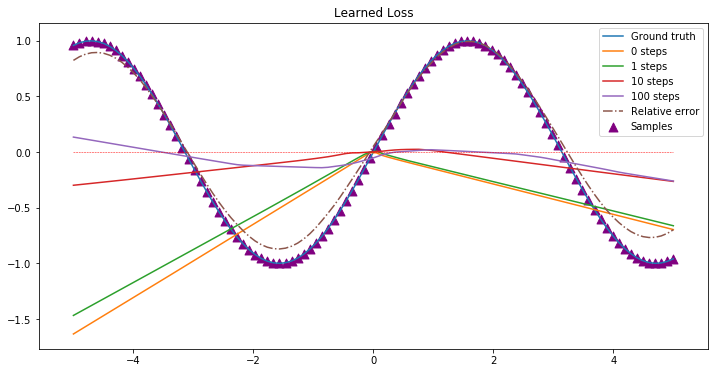

In [72]:
K = 100

X, Y = xrange_inputs[None], targets[None]

fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.plot(xrange_inputs, targets, label="Ground truth")
ax.scatter(X[1, :K], Y[1, :K], marker="^", label="Samples", color="purple", s=80)

net_params = make_multihead_net(rng_net)
# inner_opt = optix.sgd(1e-3)
opt_state = inner_opt.init(net_params)

ax.plot(xrange_inputs, multihead_apply(net_params, xrange_inputs)[0], label="0 steps")
preds = multihead_apply(net_params, xrange_inputs)[0]
pointwise_loss = (targets - preds)
print("MSE %d-shot %d steps" % (K, 0))
print((pointwise_loss ** 2).mean())


for i in range(100):
    (net_params, _), (_, _) = learned_k_updates(
        batched_learned_loss_params, net_params, X[1, :K], Y[1, :K], 1, opt_state, inner_opt.update,
    )
    
    if (i + 1) in [1, 10, 100]:
        preds = multihead_apply(net_params, xrange_inputs)[0]
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))

        # pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
        pointwise_loss = (targets - preds)
        print("MSE %d-shot %d steps" % (K, i + 1))
        print((pointwise_loss ** 2).mean())
        
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)

ax.legend()
ax.set_title("Learned Loss");